In [1]:
import sobol
import GPy
import optunity
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as st
from numpy.random import uniform

### 1 GP Optimization of a Toy Problem

a) Implementation and Plotting

<div style="color: green; font-weight: bold">
The implementation is correct. However, I really do not like your plot.

Jet is a *-terrible-* choice of colormap for any quantitative analysis, since it warps the data.
You should instead use a perceptually uniform colormap, like viridis. The matplotlib
developers held <a href="https://www.youtube.com/watch?v=xAoljeRJ3lU">a highly captivating talk on this</a>,
where they also explain the downfalls of Jet.

I am also not sure why you chose to use <code>pcolormesh</code> instead of <code>imshow</code>,
when your mesh is uniform, but this is a minor issue. Variable <code>Ny</code> is also unused.
</div>

In [2]:
def f(x,y):
    return  x**2 - x + y**2 + y - np.cos(2.0*np.pi*x - np.pi) - np.cos(2.0*np.pi*y + np.pi) + 2.5

In [3]:
Nx, Ny = 601, 601
x = np.linspace(-6.0,6.0,Nx)
x2d,y2d = np.meshgrid(x,x)

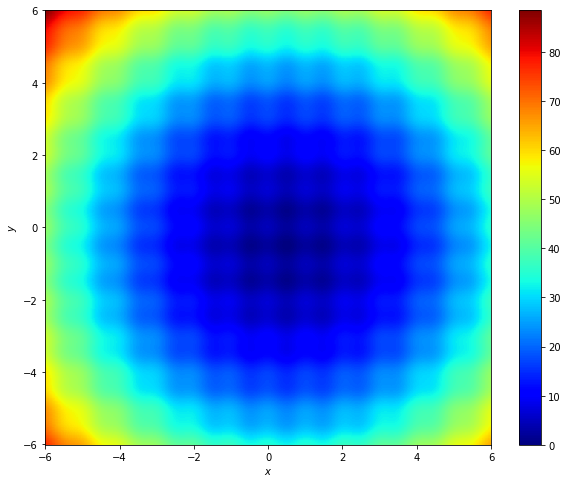

In [4]:
plt.figure(figsize=(10,8))
plt.xlabel('$x$')
plt.ylabel('$y$')
f2d = f(x2d,y2d)
plt.pcolormesh(x2d,y2d,f2d,shading='auto',cmap='jet')
plt.colorbar()
plt.show()


<div style="color: green; font-weight: bold">
Magenta is a good choice for visibility.
</div>

DescribeResult(nobs=60, minmax=(2.2011571324866113, 62.601791473379365), mean=26.912813002000068, variance=249.6494902031158, skewness=0.2748454359740778, kurtosis=-0.9532722728172192)


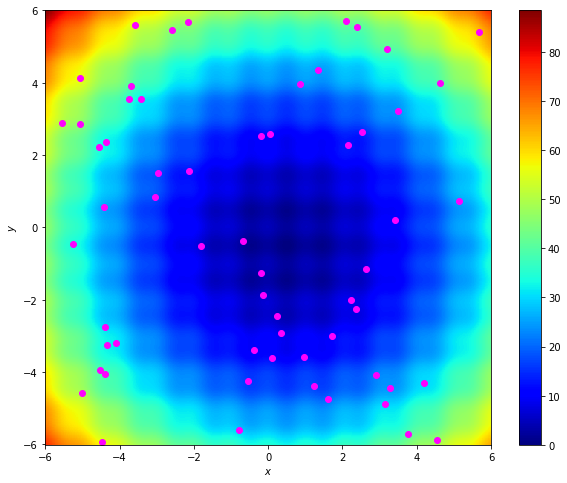

In [5]:
x,y = uniform(-6.0,6.0,size=(2,60))
print(st.describe(f(x,y)))

plt.figure(figsize=(10,8))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f2d,shading='auto',cmap='jet')
plt.colorbar()
plt.plot(x,y,linestyle='',marker='o',color='magenta')
plt.show()

### Define utility function


<div style="color: green; font-weight: bold">
Correct.
</div>

In [6]:
def expected_improvement(E_q,Var_q,E_best):
    """
    E_q, V_q = estimates of the mean and variance of the target function as returned by the Gaussian process model at point q
    E_best = current best guess of the target function's minimal value
    """
    std = np.sqrt(Var_q)
    gamma = (E_best-E_q)/std
    phi = st.norm.pdf(gamma) 
    Phi = st.norm.cdf(gamma)
    return std*(gamma*Phi+phi)

### Semi-random sobol initilization


<div style="color: green; font-weight: bold">
You call <code>f(x2d, y2d)</code> here instead of reusing <code>f2d</code>.
</div>

In [7]:
number_of_samples = 30
parameterUpperLimits = np. array ([6 ,6])
parameterLowerLimits = np. array ([ -6 , -6])
Q_initial = []

for i in range (number_of_samples):
    x,y = sobol.i4_sobol(2,i)[0] * (parameterUpperLimits - parameterLowerLimits) + parameterLowerLimits
    Q_initial.append([x,y])
    
Q_initial = np.array(Q_initial)
Qx = Q_initial[:,0]
Qy = Q_initial[:,1]

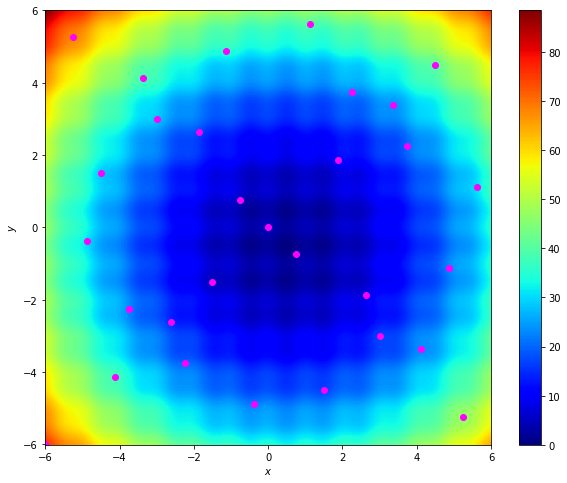

In [8]:
plt.figure(figsize=(10,8))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f(x2d,y2d),shading='auto',cmap='jet')
plt.colorbar()
plt.plot(Qx,Qy,linestyle='',marker='o',color='magenta')
plt.show()

### Create initial training set


<div style="color: green; font-weight: bold">
It was not specified on the sheet to set the variance for the <code>White</code> kernel or the model. Otherwise correct.
</div>

In [9]:
E_initial = f(Qx,Qy)
print(st.describe(E_initial))

DescribeResult(nobs=30, minmax=(2.125, 76.5), mean=26.125530904158207, variance=295.3844710954803, skewness=1.1431599824701362, kurtosis=1.5038739595038253)


In [10]:
Kernel = GPy.kern.RBF(2) + GPy.kern.White(2,variance=5e-3)
Noise = 0.0
initial_model = GPy.models.GPRegression(Q_initial,E_initial.reshape(-1,1),kernel=Kernel,noise_var=Noise)

### Initial Prediction for grid points


<div style="color: green; font-weight: bold">
Before making initial predictions from the training set, you should call <code>model.optimize()</code>.
This essentially smoothes the approximation of the dataset to a reasonable fit.
</div>

In [11]:
g = np.concatenate((x2d.reshape(-1,1),y2d.reshape(-1,1)),axis=1)
f_predicted_initial = initial_model.predict(g)

### Optimization

<div style="color: green; font-weight: bold">
Please add more comments to your code. As much as I am an advocate for self-explaining code,
this is too much of a wall of text with little to no explanation of what is going on.

It would also be nice to adhere to a line character limit,
I had to scroll horizontally here (162 characters in one line is too many).
The PEP8 standard specifies a maximum line length of 79 characters.

You never call <code>model.optimize</code>, which is detrimental to the predictive power of the GP model.
You should do this before model evaluation (i.e. after every dataset update).

See <a href="https://notebook.community/SheffieldML/notebook/lab_classes/mlss/GPy%20optimizing%20gaussian%20processes">here</a>
for plots before and after calling <code>optimize()</code> on a <code>GPy.models.GPRegression</code> model (2nd and 3rd image).

I assume this greatly affected your results, so I will treat them as-is.

Your implementation otherwise seems correct.
</div>

In [12]:
solvers = optunity.available_solvers()
print('Available solvers: ' + ', '.join(solvers))

Available solvers: grid search, random search, nelder-mead, sobol, particle swarm


In [13]:
def objective(E_best,model):
    def F(x,y):
        E_q, Var_q = model.predict(np.array([[x,y]]))
        return expected_improvement(E_q,Var_q,E_best)
    return F 

def objective_3D(E_best,model):
    def F(x,y,z):
        E_q, Var_q = model.predict(np.array([[x,y,z]]))
        return expected_improvement(E_q,Var_q,E_best)
    return F 

def objective_var(model):
    def F(x,y):
        E_q, Var_q = model.predict(np.array([[x,y]]))
        return Var_q
    return F 

def objective_var_3D(model):
    def F(x,y,z):
        E_q, Var_q = model.predict(np.array([[x,y,z]]))
        return Var_q
    return F 

def optimization_step_3D(objective_3D,E_best,current_model, num_evals=100, bounds_x=[-6.0,6.0], bounds_y=[-6.0,6.0], bounds_z=[-6.0,6.0], solver='random search'):
    obj = objective_3D(E_best,current_model)
    solution, details, _ = optunity.maximize(obj, num_evals=num_evals, x=bounds_x, y=bounds_y, z=bounds_z, solver_name=solver)
    return solution['x'], solution['y'], solution['z']

def exploring_step_3D(objective_var_3D,current_model, num_evals=100, bounds_x=[-6.0,6.0], bounds_y=[-6.0,6.0], bounds_z=[-6.0,6.0], solver='random search'):
    obj = objective_var_3D(current_model)
    solution, details, _ = optunity.maximize(obj, num_evals=num_evals, x=bounds_x, y=bounds_y, z=bounds_z, solver_name=solver) 
    return solution['x'], solution['y'], solution['z']

def optimization_step(objective,E_best,current_model, num_evals=100, bounds_x=[-6.0,6.0], bounds_y=[-6.0,6.0], solver='random search'):
    obj = objective(E_best,current_model)
    solution, details, _ = optunity.maximize(obj, num_evals=num_evals, x=bounds_x, y=bounds_y, solver_name=solver) 
    return solution['x'], solution['y']

def exploring_step(objective_var,current_model, num_evals=100, bounds_x=[-6.0,6.0], bounds_y=[-6.0,6.0], solver='random search'):
    obj = objective_var(current_model)
    solution, details, _ = optunity.maximize(obj, num_evals=num_evals, x=bounds_x, y=bounds_y, solver_name=solver) 
    return solution['x'], solution['y']

In [14]:
### initialization ###

E = np.copy(E_initial)
Q = np.copy(Q_initial)

E_best = [np.amin(E)]
arg_best = np.argmin(E)

current_model = initial_model
MU, VAR = [], []

estimated global minimum = 1.49 at [ 0.81 -0.45]


<div style="color: green; font-weight: bold">
This kind of break in your code should be done with notebook cells, not hashes.

(I added one to insert this comment).
</div>

In [ ]:
######################

max_iter = 30

for i in range(max_iter):
    qx_new, qy_new = optimization_step(objective=objective,E_best=np.amin(E_best),current_model=current_model)

    E_new = f(qx_new, qy_new)
    
    E_best.append(E_new)
    mu, var = current_model.predict(np.array([[qx_new,qy_new]]))
    MU.append(mu.item())
    VAR.append(var.item())
    
    E = np.append(E,E_new)
    Q = np.concatenate((Q,np.array([[qx_new,qy_new]])),axis=0)    
    current_model = GPy.models.GPRegression(Q,E.reshape(-1,1),kernel=Kernel,noise_var=Noise)

minimum, argminimum = np.amin(E_best), np.argmin(E_best)

if argminimum == 0:
    argminimum = arg_best
else:
    argminimum = -max_iter-1+argminimum 
    
Q_min = Q[argminimum]

print('estimated global minimum =',minimum.round(2),'at',Q_min.round(2))

f_predicted_final1 = current_model.predict(g)


<div style="color: green; font-weight: bold">
This plot is good. Good job showing the uncertainty of the model, though a shaded area is usually
more intuitively interpretable than errorbars.
</div>

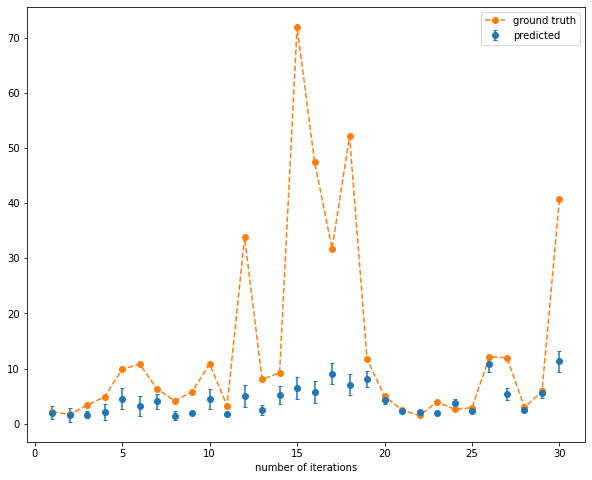

In [15]:
u = 1.0+np.arange(max_iter)

plt.figure(figsize=(10,8))
plt.errorbar(u,MU,yerr=2*np.sqrt(VAR),capsize=2,linestyle='',marker='o',label='predicted')
plt.plot(u,E_best[1:],linestyle='--',marker='o',label='ground truth')
plt.xlabel('number of iterations')
plt.legend()


<div style="color: green; font-weight: bold">
Good plot. It would have been nice if you adjusted the color of the extra points based on the
iteration number. That way, you can see if your model is progressively getting better or
moving in circles.
</div>

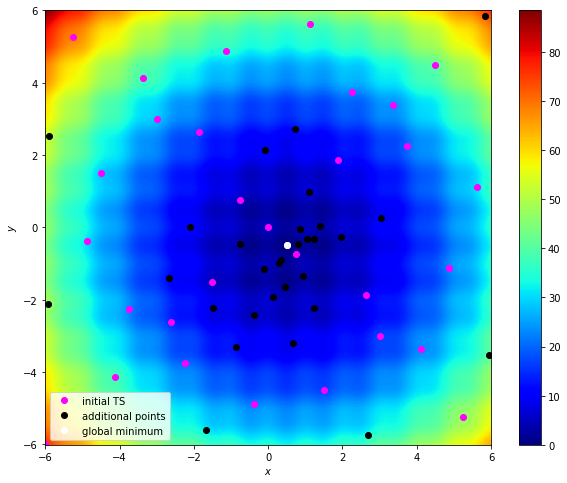

In [16]:
plt.figure(figsize=(10,8))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f(x2d,y2d),shading='auto',cmap='jet')
plt.colorbar()
plt.plot(Q[0:number_of_samples,0],Q[0:number_of_samples,1],linestyle='',marker='o',color='magenta',label='initial TS')
plt.plot(Q[number_of_samples:,0],Q[number_of_samples:,1],linestyle='',marker='o',color='black',label='additional points')
plt.plot((0.5,0.5),(-0.5,-0.5),linestyle='',marker='o',color='white',label='global minimum')
plt.legend(loc='lower left')
plt.show()

Points are added especially in the near of the global minimum at $[0.5,-0.5]$, which means that a function $\hat{f}$ is learned that is getting more and more similiar to $f(x,y)$ near the global minimum while in far away regions $\hat{f}$ can be very different in general. 

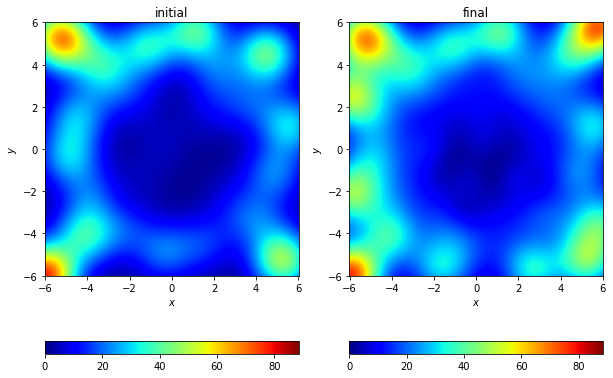

In [17]:
plt.figure(figsize=(10,8))
plt.subplot(121,aspect=1.0)
plt.title('initial')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f_predicted_initial[0].reshape(Nx,Ny),shading='auto',cmap='jet',vmin=np.amin(f2d),vmax=np.amax(f2d))
plt.colorbar(orientation='horizontal')
plt.subplot(122,aspect=1.0)
plt.title('final')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f_predicted_final1[0].reshape(Nx,Ny),shading='auto',cmap='jet',vmin=np.amin(f2d),vmax=np.amax(f2d))
plt.colorbar(orientation='horizontal')

In [18]:
### initialization ###

E = np.copy(E_initial)
Q = np.copy(Q_initial)

E_best = [np.amin(E)]
arg_best = np.argmin(E)

current_model = initial_model
MU, VAR = [], []

######################

max_iter = 30

for i in range(max_iter):
    if i&2==0:
        qx_new, qy_new = exploring_step(objective_var=objective_var,current_model=current_model)
    else:
        qx_new, qy_new = optimization_step(objective=objective,E_best=np.amin(E_best),current_model=current_model)
    
    E_new = f(qx_new, qy_new)
    E_best.append(E_new)
    
    mu, var = current_model.predict(np.array([[qx_new,qy_new]]))
    MU.append(mu.item())
    VAR.append(var.item())
    
    #print(E_new,qx_new,qy_new)
    
    E = np.append(E,E_new)
    Q = np.concatenate((Q,np.array([[qx_new,qy_new]])),axis=0)    
    current_model = GPy.models.GPRegression(Q,E.reshape(-1,1),kernel=Kernel,noise_var=Noise)

minimum, argminimum = np.amin(E_best), np.argmin(E_best)

if argminimum == 0:
    argminimum = arg_best
else:
    argminimum = -max_iter-1+argminimum 
    
Q_min = Q[argminimum]

print('estimated global minimum =',minimum.round(2),'at',Q_min.round(2))

f_predicted_final2 = current_model.predict(g)

estimated global minimum = 1.45 at [ 0.43 -1.29]


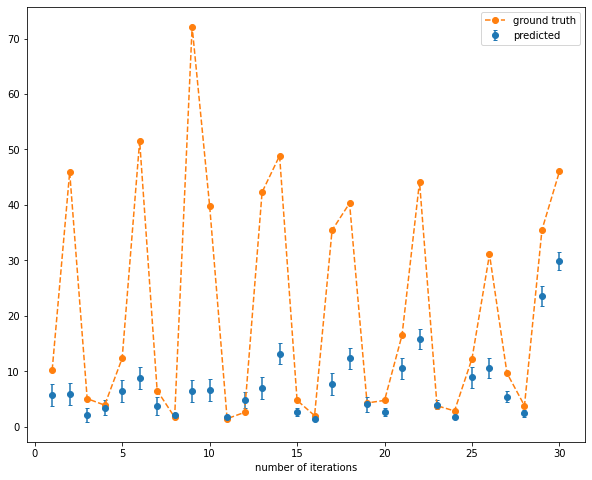

In [19]:
u = 1.0+np.arange(max_iter)
plt.figure(figsize=(10,8))
plt.errorbar(u,MU,yerr=2*np.sqrt(VAR),capsize=2,linestyle='',marker='o',label='predicted')
plt.plot(u,E_best[1:],linestyle='--',marker='o',label='ground truth')
plt.xlabel('number of iterations')
plt.legend()

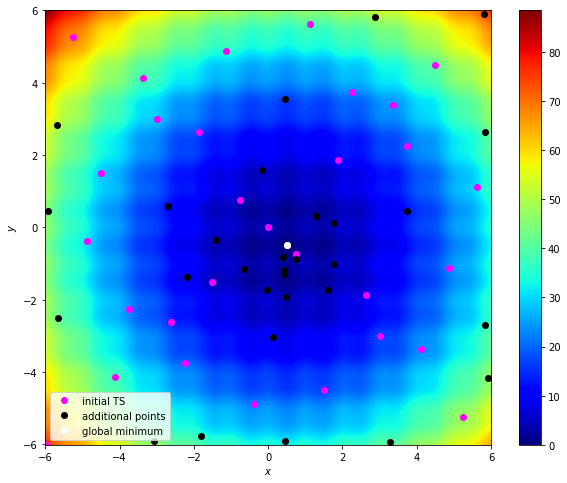

In [20]:
plt.figure(figsize=(10,8))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f(x2d,y2d),shading='auto',cmap='jet')
plt.colorbar()
plt.plot(Q[0:number_of_samples,0],Q[0:number_of_samples,1],linestyle='',marker='o',color='magenta',label='initial TS')
plt.plot(Q[number_of_samples:,0],Q[number_of_samples:,1],linestyle='',marker='o',color='black',label='additional points')
plt.plot((0.5,0.5),(-0.5,-0.5),linestyle='',marker='o',color='white',label='global minimum')
plt.legend(loc='lower left')
plt.show()

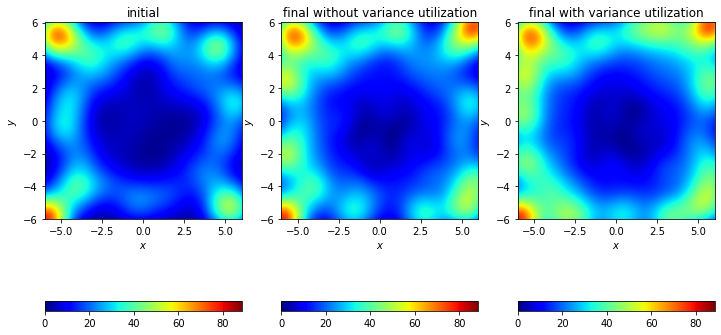

In [21]:
plt.figure(figsize=(12,10))
plt.subplot(131,aspect=1.0)
plt.title('initial')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f_predicted_initial[0].reshape(Nx,Ny),shading='auto',cmap='jet',vmin=np.amin(f2d),vmax=np.amax(f2d))
plt.colorbar(orientation='horizontal')
plt.subplot(132,aspect=1.0)
plt.title('final without variance utilization')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f_predicted_final1[0].reshape(Nx,Ny),shading='auto',cmap='jet',vmin=np.amin(f2d),vmax=np.amax(f2d))
plt.colorbar(orientation='horizontal')
plt.subplot(133,aspect=1.0)
plt.title('final with variance utilization')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.pcolormesh(x2d,y2d,f_predicted_final2[0].reshape(Nx,Ny),shading='auto',cmap='jet',vmin=np.amin(f2d),vmax=np.amax(f2d))
plt.colorbar(orientation='horizontal')


<div style="color: green; font-weight: bold">
Your observations are mostly correct. The variance function leads to a greater exploration of the
function space. The discrepancy comes from not optimizing the model. We do evaluate enough points here
for the GP to yield good results in approximating the global shape of the function.
</div>

As expected, the main difference compared to the optimization without variance utilization is that a wider range of the function is learned. Additional points are widespread on the whole space $[-6,6]^2$. We think it is not necessary for this simple toy problem. Due to we are evaluating only a few points, in both methods there is quite often a huge discrepancy between ground truth $f(x,y)$ and the expected value predicted from the model, also when you take into account the expected variance. Using variance utilization leads to more such discrepancies. In both cases, a higher number of iterations should increase the result further.

 Which requirements should the function $f(x, y)$ fulfil in order for this method to work?
 - Should work quite well for each function $f(x,y)$ that can be approximated by Gaussian Process regression

### 2 Reconstruction of a Corrupted Image


<div style="color: green; font-weight: bold">
Since this is no longer a gaussian kernel, it would have been nice to rename it.
But the sample solution also did not do this.

You used a different <code>limit</code> than the sample solution, but this should only have a scaling effect on
your hyperparameters. In fact, you already compensate for this by setting your <code>max_distance</code> differently.

Otherwise this is correct.
</div>

In [22]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial

opt_print = lambda *args, **kwargs: None  # silence output

# opt_print = print # for debugging

def gaussian_kernel(data, sigma, gamma, max_distance):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the generalized expontential kernel
    :gamma: parameter gamma of the generalized expontential kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2
    assert sigma > 0

    
    factor = -1.0/sigma ** gamma
    limit = np.exp(factor * max_distance ** gamma)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        r = np.sqrt(np.sum((data - k) ** 2, axis=1))
        d = np.exp(factor * r ** gamma)
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:, None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K


def compute_alpha(train_x, train_y, tau, sigma, gamma, max_distance, verbose=False):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :param verbose: Print debugging information?
    :return: alpha vector
    """
    if verbose: print("Building input kernel matrix")
    K = gaussian_kernel(train_x, sigma, gamma, max_distance)
    if verbose: print("Sparsity is: %.2f%%" % (
            float(100 * K.nnz) / (K.shape[0] * K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:, None])
    if verbose: print("Solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    if verbose: print("Done computing alpha")
    return alpha[0]


class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau, sigma, gamma):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.sigma = sigma
        self.gamma = gamma
        self.scale = -0.5 / sigma**2
        self.max_distance = 8.0**(1.0/gamma)*sigma

    def train(self, train_x, train_y, verbose=False):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(np.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau,
                                   self.sigma, self.gamma, self.max_distance,
                                   verbose=verbose)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = np.asarray(self.tree.query_ball_point(pred_x, self.max_distance),dtype=np.dtype("i8"))
        dist = np.sum((self.train_x[indices] - pred_x) ** 2, axis=1)
        kappa = np.exp(self.scale * dist)
        pred_y = np.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(np.float32)
        return np.array([self.predict_single(x) for x in pred_x])


def kernel_ridge_regression(tau, sigma, gamma, verbose=False):
    # Load the image.
    im_orig = np.squeeze(plt.imread("cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = np.array(im_orig)

    # Find the known pixels and the pixels that shall be predicted.
    known_ind = np.where(im != 0)
    # predict everywhere, use im == 0 to predict only unfilled values
    unknown_ind = np.where(im >= 0)
    known_x = np.array(known_ind).transpose()
    known_y = np.array(im[known_ind])
    pred_x = np.array(unknown_ind).transpose()

    # Train and predict with the given regressor.
    start = time.time()
    if verbose: print("Training...")
    r = KernelRidgeRegressor(tau, sigma, gamma)
    r.train(known_x, known_y, verbose=verbose)
    if verbose: print("Done training.")

    if verbose: print("Predicting... ", end="")
    pred_y = r.predict(pred_x)
    if verbose: print("Done.")

    # Write the predicted values back into the image and show the result.
    im[unknown_ind] = pred_y
    stop = time.time()
    if verbose: print("Train and predict took %.02f seconds." % (stop - start))
    if verbose: print(im.shape)

    return im

In [23]:
corrupted = plt.imread('cc_90.png')
original = plt.imread('charlie-chaplin.jpg')

def Comparison(im1,im2,im3,titles,cmap='gray'):
    title, title1, title2, title3 = titles
    plt.figure(figsize=(20,5))
    plt.suptitle(title)
    plt.subplot(131)
    plt.title(title1)
    plt.axis('off')
    plt.imshow(im1,cmap=cmap)
    plt.subplot(132)
    plt.title(title2)
    plt.axis('off')
    plt.imshow(im2,cmap=cmap)
    plt.subplot(133)
    plt.title(title3)
    plt.axis('off')
    plt.imshow(im3,cmap=cmap)

<div style="color: green; font-weight: bold">
Correct implementation and plots.
</div>

In [ ]:
tau, sigma, gamma = 0.8,3.0,1.0

im_initial = kernel_ridge_regression(tau, sigma, gamma, verbose=True)
Comparison(corrupted,original,im_initial,titles=[r'$\tau={},\sigma={},\gamma={}$'.format(tau,sigma,gamma),'corrupted','original','reconstructed'])

<div style="color: green; font-weight: bold">
Both answers are correct.
</div>

The code does not contain explicit matrix inversion. How is the inverse of K applied instead?

The code uses a linear equation solver (for sparse matrices, scipy.sparse.linalg.cg) to determine $\alpha=(K+\mathbb{1}\tau)^{-1}y_{\text{train}}$ from the linear equation system $(K+\mathbb{1}\tau)\alpha=y_{\text{train}}$.

Which data structure was used to speed up the prediction and why is this a good idea?

The code uses scipys sparse matrix implementation to efficently skip all the zeros in $A=(K+\mathbb{1}\tau)$ which also saves a lot of memory. Note that $A_{ij}$ in general is only much different from zero when the distance of the corresponding inputs $x_i$ and $x_j$ is small. Thus, a lot of entries will be equal to zero. 

### 3 Bayesian Optimization of Hyperparameters


<div style="color: green; font-weight: bold">
Correct implementation. The sample solution uses two <code>np.sum</code>s, but this is unnecessary.
</div>

In [25]:
def Cor(A,B):
    Amean = np.mean(A)
    Bmean = np.mean(B)
    a = A-Amean
    b = B-Bmean
    Z = np.sum(a*b)
    N = np.sqrt(np.sum(a**2))*np.sqrt(np.sum(b**2))
    return Z/N

print('Initial COR=',Cor(original,im_initial).round(3))

Initial COR= 0.92


### Semi-random sobol initilization


<div style="color: green; font-weight: bold">
Correct.
</div>

In [26]:
number_of_samples = 30
parameterUpperLimits = np.array([1.0,7.0,4.0])
parameterLowerLimits = np.array([0.005,1.0,1.0])
Q_initial = []

for i in range (number_of_samples):
    x,y,z = sobol.i4_sobol(3,i)[0] * (parameterUpperLimits - parameterLowerLimits) + parameterLowerLimits
    Q_initial.append([x,y,z])

Q_initial = np.array(Q_initial)
E_initial = []

for i in range(len(Q_initial)):
    tau, sigma, gamma = Q_initial[i]
    im = kernel_ridge_regression(tau, sigma, gamma, verbose=False)
    Loss = 1.0-Cor(original,im)
    E_initial.append(Loss)
    
E_initial = np.array(E_initial)

<div style="color: green; font-weight: bold">
Changing the length scales of your kernel will affect the resolution of your function approximation in
that dimension. This was not specified to do on the sheet (we want to optimize $\theta = (\tau, \sigma \gamma)$),
but I will assume you did this as part of a separate hyperparameter optimization.
</div>

In [ ]:
Kernel = GPy.kern.Matern52(3,lengthscale=[1.0,4.0,1.0],ARD=True)
Noise = 0.0
initial_model = GPy.models.GPRegression(Q_initial,E_initial.reshape(-1,1),kernel=Kernel,noise_var=Noise)



<div style="color: green; font-weight: bold">
Looks good. As before, you do not <code>optimize</code> the model.
</div>

In [28]:
### initialization ###

E = np.copy(E_initial)
Q = np.copy(Q_initial)

E_best = [np.amin(E)]
arg_best = np.argmin(E)

current_model = initial_model
MU, VAR = [], []

######################

max_iter = 30

for i in range(max_iter):
    
    if i%2==0:
        qx_new, qy_new, qz_new = exploring_step_3D(objective_var_3D, current_model, num_evals=100, bounds_x=[0.005,1.0], bounds_y=[1.0,7.0], bounds_z=[1.0,4.0], solver='random search')
    else:
        qx_new, qy_new, qz_new = optimization_step_3D(objective_3D,np.amin(E_best),current_model, num_evals=100, bounds_x=[0.005,1.0], bounds_y=[1.0,7.0], bounds_z=[1.0,4.0], solver='random search')
        
    im_new = kernel_ridge_regression(qx_new, qy_new, qz_new, verbose=False)
    E_new = 1.0-Cor(original,im_new)
    E_best.append(E_new)
    mu, var = current_model.predict(np.array([[qx_new,qy_new,qz_new]]))
    MU.append(mu.item())
    VAR.append(var.item())
    E = np.append(E,E_new)
    Q = np.concatenate((Q,np.array([[qx_new,qy_new,qz_new]])),axis=0)    
    current_model = GPy.models.GPRegression(Q,E.reshape(-1,1),kernel=Kernel,noise_var=Noise)

minimum, argminimum = np.amin(E_best), np.argmin(E_best)

if argminimum == 0:
    argminimum = arg_best
else:
    argminimum = -max_iter-1+argminimum 

Q_min = Q[argminimum]

print('estimated global minimum =',minimum.round(3),'at',Q_min.round(2))


estimated global minimum = 0.068 at [0.02 3.8  1.54]


<div style="color: green; font-weight: bold">
Plot looks good.
</div>

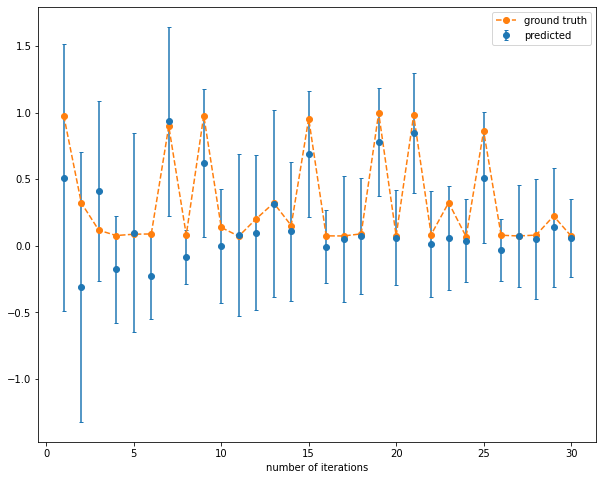

In [37]:
u = 1.0+np.arange(max_iter)

plt.figure(figsize=(10,8))
plt.errorbar(u,MU,yerr=2*np.sqrt(VAR),capsize=2,linestyle='',marker='o',label='predicted')
plt.plot(u,E_best[1:],linestyle='--',marker='o',label='ground truth')
plt.xlabel('number of iterations')
plt.legend()


<div style="color: green; font-weight: bold">
Can you really assume this? You would need another plot to prove it.
</div>

Note that the variance seems to decrease over the number of iterations.

In [38]:
tau_min, sigma_min, gamma_min = Q_min
im_min = kernel_ridge_regression(tau_min, sigma_min, gamma_min, verbose=False)

In [39]:
print('Final COR=',Cor(original,im_min).round(3))

Final COR= 0.932


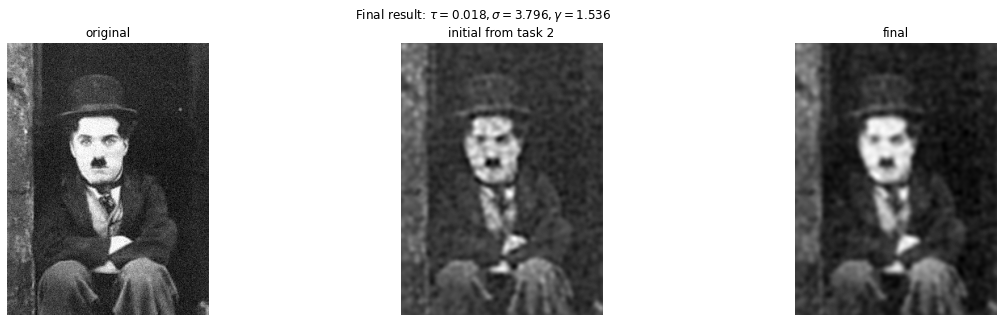

In [40]:
Comparison(original,im_initial,im_min,titles=[r'Final result: $\tau={},\sigma={},\gamma={}$'.format(tau_min.round(3),sigma_min.round(3),gamma_min.round(3)),'original','initial from task 2','final'])

<div style="color: green; font-weight: bold">
I would argue the reconstruction is significantly better. Especially macroscopic features like the dark black
in the center background or the white plateau of Chaplin's forehead are more visible in the final result.
Notably this does also come down to noise reduction, but the improvement is significant.
</div>

The final reconstructed image is only sligthly improved compared to the intial reconstruction from task 2 (less noise).